In [8]:
import os.path
import pickle
from typing import List, Dict

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path

In [9]:
mnist_dates = ['20220513-162152', '20220513-203630', '20220515-185834', '20220516-181630']
mnist_filepaths = {
    350: 'mnist/out/mnist_350_20220513-162152.pickle',
    630: 'mnist/out/mnist_630_20220513-162152.pickle',
    1136: 'mnist/out/mnist_1136_20220513-162152.pickle',
    2046: 'mnist/out/mnist_2046_20220513-162152.pickle',
    3687: 'mnist/out/mnist_3687_20220513-162152.pickle',
    6643: 'mnist/out/mnist_6643_20220513-162152.pickle',
    11969: 'mnist/out/mnist_11969_20220513-203630.pickle',
    21565: 'mnist/out/mnist_21565_20220513-203630.pickle',
    38853: 'mnist/out/mnist_38853_20220513-203630.pickle',
    70000: 'mnist/out/mnist_70000_20220515-185834.pickle',

}
mnist_filepaths = { key: [f"mnist/out/mnist_{key}_{date}.pickle" for date in mnist_dates] for key in mnist_filepaths.keys() }
cifar_dates = ['20220514-220438', '20220515-174248']
cifar_filepaths = {
    250: 'cifar10/out/cifar_250_20220514-220438.pickle',
    450: 'cifar10/out/cifar_450_20220514-220438.pickle',
    811: 'cifar10/out/cifar_811_20220514-220438.pickle',
    1462: 'cifar10/out/cifar_1462_20220514-220438.pickle',
    2634: 'cifar10/out/cifar_2634_20220514-220438.pickle',
    4745: 'cifar10/out/cifar_4745_20220514-220438.pickle',
    8549: 'cifar10/out/cifar_8549_20220514-220438.pickle',
    15403: 'cifar10/out/cifar_15403_20220514-220438.pickle',
    27752: 'cifar10/out/cifar_27752_20220514-220438.pickle',
    50000: 'cifar10/out/cifar_50000_20220514-220438.pickle',
}
cifar_filepaths = { key: [f"cifar10/out/cifar_{key}_{date}.pickle" for date in cifar_dates] for key in cifar_filepaths.keys() }
house_dates = ['20220512-201443', '20220516-203233', '20220512-21434', '20220516-075525', '20220518-204250']
house_filepaths = {
    101: 'house/out/house_101_20220512-201443.pickle',
    182: 'house/out/house_182_20220512-201443.pickle',
    329: 'house/out/house_329_20220512-201443.pickle',
    593: 'house/out/house_593_20220512-201443.pickle',
    1070: 'house/out/house_1070_20220512-201443.pickle',
    1927: 'house/out/house_1927_20220512-201443.pickle',
    3473: 'house/out/house_3473_20220512-201443.pickle',
    6257: 'house/out/house_6257_20220512-214341.pickle',
    11274: 'house/out/house_11274_20220512-214341.pickle',
    20313: 'house/out/house_20313_20220516-075525.pickle',
}
house_filepaths = { key: [f"house/out/house_{key}_{date}.pickle" for date in house_dates] for key in house_filepaths.keys() }

In [10]:
def load(all_paths: Dict[int, str]):
    def load_paths(all_paths):
        for _, paths in all_paths.items():
            if type(paths) is str:
                paths = [paths]
            for path in paths:
                full_path = Path.cwd().parent / path
                if os.path.exists(full_path):
                    with open(full_path, 'rb') as f:
                        for model, measurements in pickle.load(f).items():
                            df = pd.DataFrame(index=range(len(measurements)))
                            df['model'] = model
                            df['test_score_mean'] = np.mean(measurements['test_score'])
                            df['train_score_mean'] = np.mean(measurements['train_score'])
                            df['fit_time_mean'] = np.mean(measurements['fit_time'])
                            df['n_used_train_samples'] = np.mean(measurements['n_used_train_samples'])
                            yield df

    df = pd.concat(load_paths(all_paths), axis=0, ignore_index=True)

    return df

house_df = load(house_filepaths)
cifar_df = load(cifar_filepaths)
mnist_df = load(mnist_filepaths)

In [11]:
def plot_y(df: pd.DataFrame, y: str, x_log = False, y_log = False, ax=None):
    g = sns.lineplot(
        x='n_used_train_samples',
        y=y,
        hue='model',
        data=df,
        ax=ax,
    )
    if x_log:
        g.set(xscale='log')
        g.set_xticks(df.n_used_train_samples.values)
        for tick in g.get_xticklabels():
            tick.set_rotation(90)
        g.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    if y_log:
        g.set(yscale='log')
    return g

In [12]:
def plot_data(df, title, models):
    fig, ax = plt.subplots(1, 3, figsize=(18,6))
    fig.suptitle(title)
    ax[0].set_title('Test Score')
    ax[0].set_ylim(0, 1)
    plot_y(df.loc[df['model'].isin(models)], 'test_score_mean', x_log=True, ax=ax[0])
    ax[1].set_title('Train Score')
    ax[1].set_ylim(0, 1)
    plot_y(df.loc[df['model'].isin(models)], 'train_score_mean', x_log=True, ax=ax[1])
    ax[2].set_title('Fit time (cache)')
    plot_y(df.loc[df['model'].isin(models)], 'fit_time_mean', x_log=True, y_log=True, ax=ax[2])
    plt.show()

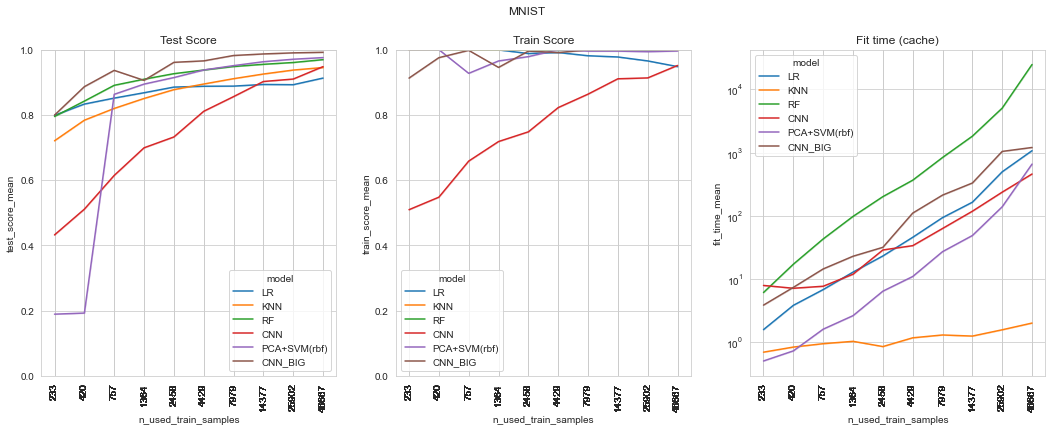

In [13]:
plot_data(mnist_df, 'MNIST', models = ['LR', 'KNN', 'RF', 'PCA+SVM(rbf)', 'NN', 'CNN', 'CNN_BIG'])

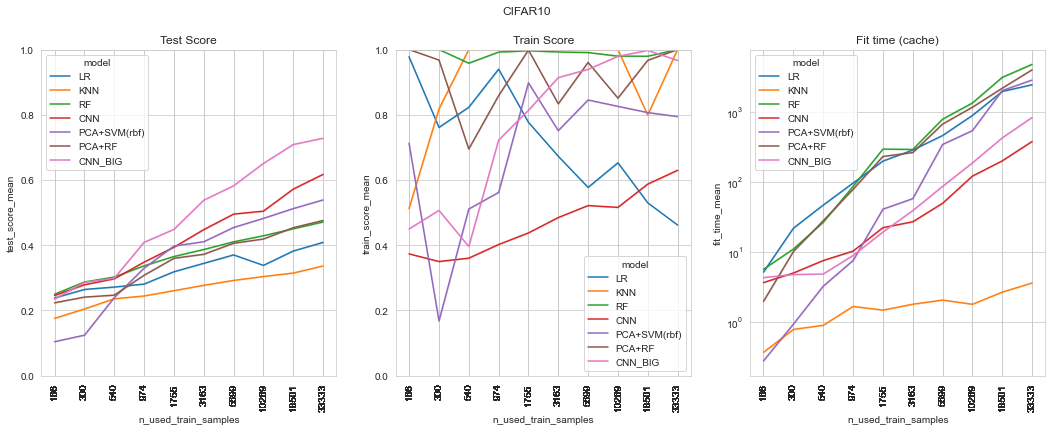

In [14]:
plot_data(cifar_df, 'CIFAR10', models = ['LR', 'KNN', 'RF', 'PCA+RF', 'PCA+SVM(rbf)', 'NN', 'CNN', 'CNN_BIG'])

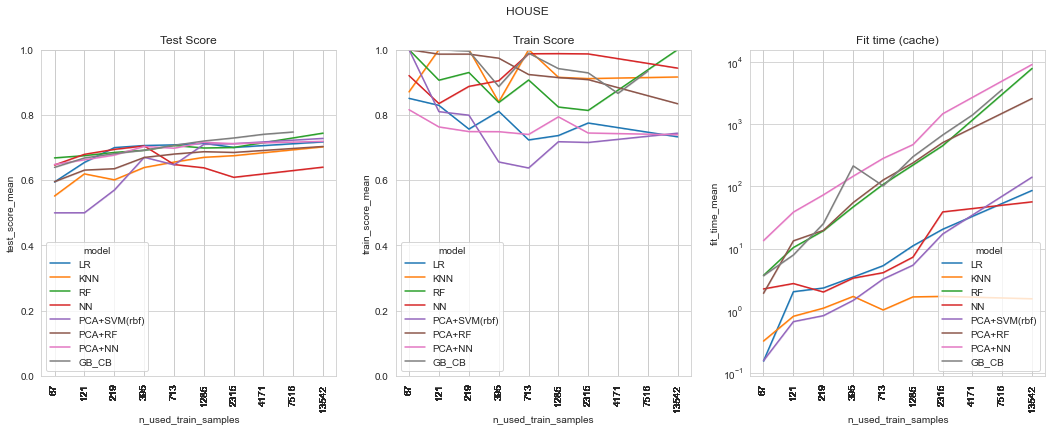

In [15]:
plot_data(house_df, 'HOUSE', models = ['LR', 'KNN', 'RF', 'GB_CB', 'PCA+RF', 'PCA+SVM(rbf)', 'NN', 'PCA+NN'])